## Spatial Structure of Rain

Import the class object RainGage and initialize it with a file containing all of the data or with a list of years. The output from this are all contained in attributes of the ** `RainGage`** class. All of the data are contained in a **`pandas.DataFrame`** object called **`RainGage.df`**

In [1]:
%matplotlib inline
from rain import *
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri

** Philadelphia:**

In [ ]:
path = "./input/"
rg = Rain(path=path, df_file="Philadelphia_raingage_1996_2015_NAN_filled_time_indexed.dat")

In [ ]:
rg.get_ll()

**St. Louis: **

In [2]:
path = 'C:/Users/Julia/Google Drive/STLOUIS/'

rg = Rain(path=path, name='StLouis_gage_{YEAR}_UTC_reordered.dat', year=range(2009,2015), ngages=101, units='in')
rad = Rain(path=path, name='StLouis_radar_{YEAR}_UTC_reordered.dat', year=range(2009,2015), ngages=101, units='mm')

In [3]:
rg.ll_file = 'll_loc{YEAR}.txt'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll

### Plot distances between gages

In [4]:
rg.save_path = './output/StLouis/'

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


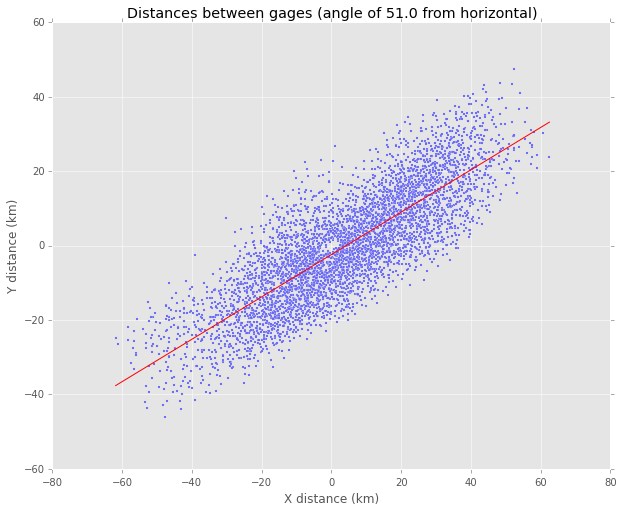

In [5]:
rg.plot_ll()

### Wettest times

For these semi variograms we only allow times in which all the gages record non-zero values. From those select times we pull out the largest accumultations and store them in a **`pandas.DataFrame`** object called **`RainGage.wettest`**. This dataframe is the transpose of earlier dataframes and includes both euclidian and latlon coordinates for each rain gage.  

In [ ]:
rg.get_wettest()

In [ ]:
rg.wettest.head()

You will notice that we have a new SVG_data file saved in our home dir. This was created within the get_wettest function. This file will be used as input to the semivariogram calculation in r. You can set the keyword arguments for the r function by changing the values within the quotes.

In [ ]:
# run r commands to get the SVG
foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
        'source("SVG.r") \n'+
        'SVG_tab <- get_SVG(SVG_data, last_max=TRUE, cressie=TRUE)\n'
        )
df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['SVG_tab']))
df.index = df.dist
names=['np', 'dist']
for t in rg.wettest.columns[5::]:
    names.append(t)
df.columns = names

And you can plot the output right here in the notebook:

In [ ]:
df[range(2,len(df.columns))].plot(style='o', figsize=(8, 8), xlim=(1,15), legend=False)
plt.legend(bbox_to_anchor=(1.5, 0.6))
plt.show()

### A particular storm

This operates similarly to the wettest section, but for these semi variograms we are interested in tracking a timespan, such as one particular storm. To this end, we allow times in which some gages record zeros. Again, we pull out the times of interest and store them in a **`pandas.DataFrame`** object called **`RainGage.storm`**. This dataframe is the transpose of earlier dataframes and includes both euclidian and latlon coordinates for each rain gage.  

In [6]:
rad.ll = rg.ll

In [7]:
rad.get_storm('2011-06-26',time_step='1H')

Since the number of gages for each time is not consistant, we need to calculate the number of interdistances (np) to make sure that we have about 30 in each bin. So we calculate the semivariogram for each site separately and then aggregate the results

In [17]:
def SVG_storm(rg):
    s = {}
    d = {}
    bar = {}
    for i, col in enumerate(rg.storm):
        if col not in rg.ll.columns:
            foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
                    'source("SVG.r") \n'+
                    'iSVG_tab <- get_iSVG(SVG_data, {index}, target_np=5 alpha=39, tol.hor=20, last_max=FALSE, cressie=FALSE)\n'.format(index=i+1)
                    )
            df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['iSVG_tab']))
            try:
                df.index = df.dist
            except:
                continue
            d.update({col: df})
            pdf = df[:]
            pdf.columns = ['np', 'dist', col, 'dir.hor', 'dir.vert', 'id']
            bar.update({col: pdf[col]})
            s.update({col: (df['gamma'].idxmax(axis=0), df['np'].sum())})
    df = pd.DataFrame(s).transpose()
    plotting_df = pd.DataFrame(bar.values()).transpose()
    df.columns=['dist', 'np']
    return plotting_df, df, d

def plot_range(df):
    ax = df['dist'].plot(figsize=(16,6), style='o')
    plt.ylabel('Range distance between gages (km)')
    plt.title('Range distance')
    for i, val in enumerate(df['dist']):
        ax.annotate(s = int(df['np'][i]), xy=(df['dist'].index[i], val))
    plt.show()

In [18]:
pdf, df, d = SVG_storm(rad)

ValueError: Error while parsing the string.

We have access to the raw results by looking inside the **`dictionary`** called **`d`**. This contains all of the variograms with the times at which they occur as the keys. These keys are **`pandas.Timestamp`** objects, so we can call flexibly as shown below. Note that they are not ordered.

In [10]:
d.keys()[0:2]

[Timestamp('2011-06-26 02:00:00'), Timestamp('2011-06-26 09:00:00')]

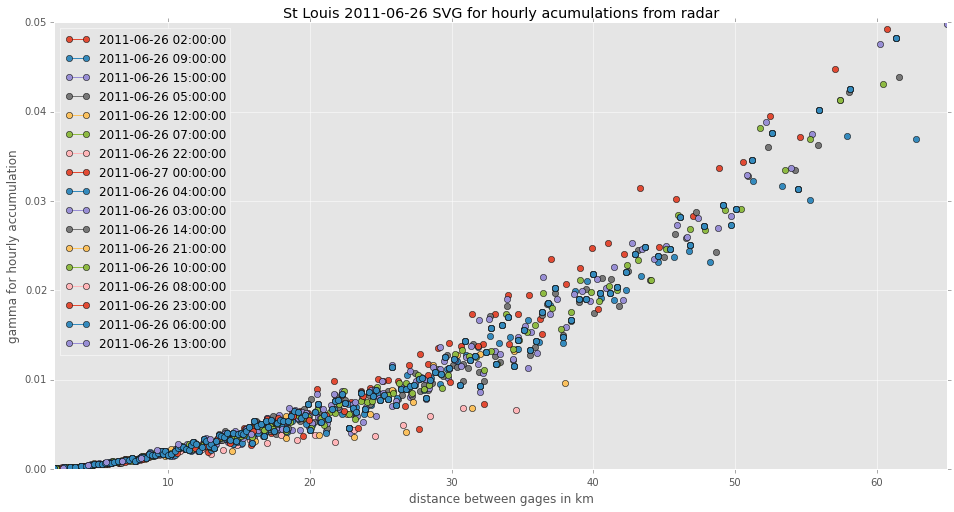

In [11]:
title = 'St Louis 2011-06-26 SVG for hourly acumulations from radar'

pdf.plot(marker = 'o', figsize=(16,8))
plt.ylabel('gamma for hourly accumulation')
plt.xlabel('distance between gages in km')
plt.title(title)
plt.savefig(rg.save_path+'{title}.jpg'.format(title=title))
plt.show()

If we prefer to see the plot of the aggregated results:

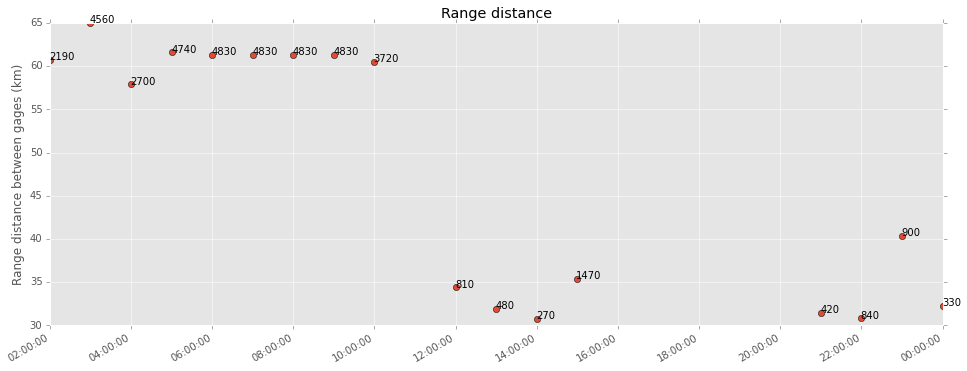

In [12]:
plot_range(df)

### Rainiest Days

This is an attempt to look at the rainiest days using a similar method to that described above. The first step is to select the days.  A straightforward approach is to compute the mean daily rainfall (with a day defined from 12 UTC to 12 UTC to reflect the diurnal cycle of rainfall, especially for the warm season) as the average of all rain gage observations for stations that are active and just rank the days.

In [136]:
p = RadarGage(gage=rg, radar=rad)
p.save_path = './output/StLouis/'

In [14]:
p.get_rainiest(4)

In [217]:
ga = rg.rate.loc['2011-06-17 12:00':'2011-06-18 12:00']

In [212]:
ga_mean = ga.mean()
ga_mean.head()

RG
RG1    13.208000
RG2    18.010909
RG3    12.700000
RG4    14.901333
RG5    14.562667
dtype: float64

In [161]:
ra = rad.rate.loc['2011-06-17 12:00':'2011-06-18 12:00']

In [218]:
ra_mean = ra.mean()
ra_mean.head()

RG
RG1    10.702857
RG2    11.272727
RG3     9.120000
RG4    11.130000
RG5    17.817778
dtype: float64

In [221]:
t = ra.isnull()
foo = list(t[t > 0].stack().index)

In [222]:
for f in foo:
    ga.set_value(f[0], f[1], np.nan)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


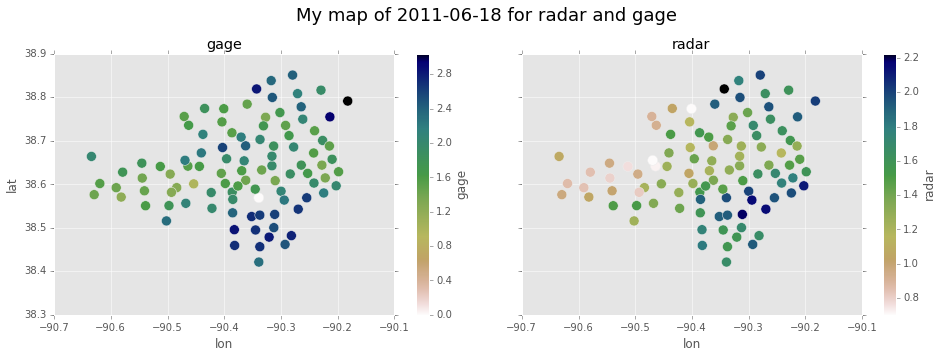

In [198]:
df = p.ll.join(pd.DataFrame({'gage': p.rate.gage['2011-06-17 12:00': '2011-06-18 12:00'].mean()}))
df = df.join(pd.DataFrame({'radar': p.rate.radar['2011-06-17 12:00': '2011-06-18 12:00'].mean()}))
df = df[df.lat!=0]
map_rain(df, save_path=p.save_path, title='My map of 2011-06-18 for radar and gage')

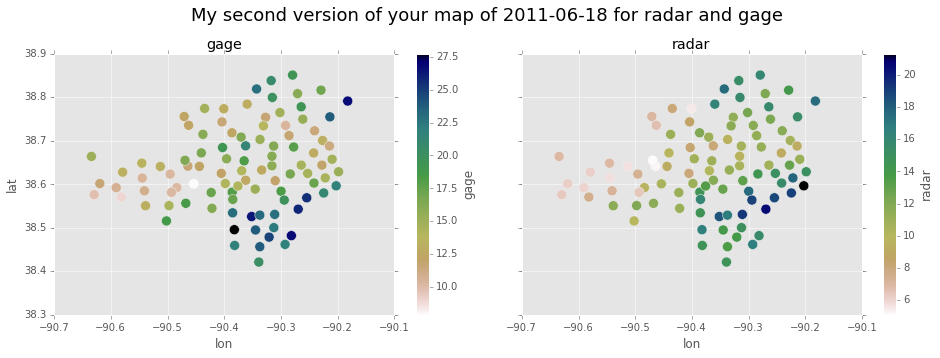

In [223]:
df = p.ll.join(pd.DataFrame({'gage': ga.mean()}))
df = df.join(pd.DataFrame({'radar': ra.mean()}))
df = df[df.lat!=0]
map_rain(df, save_path=p.save_path, title='My second version of your map of 2011-06-18 for radar and gage')

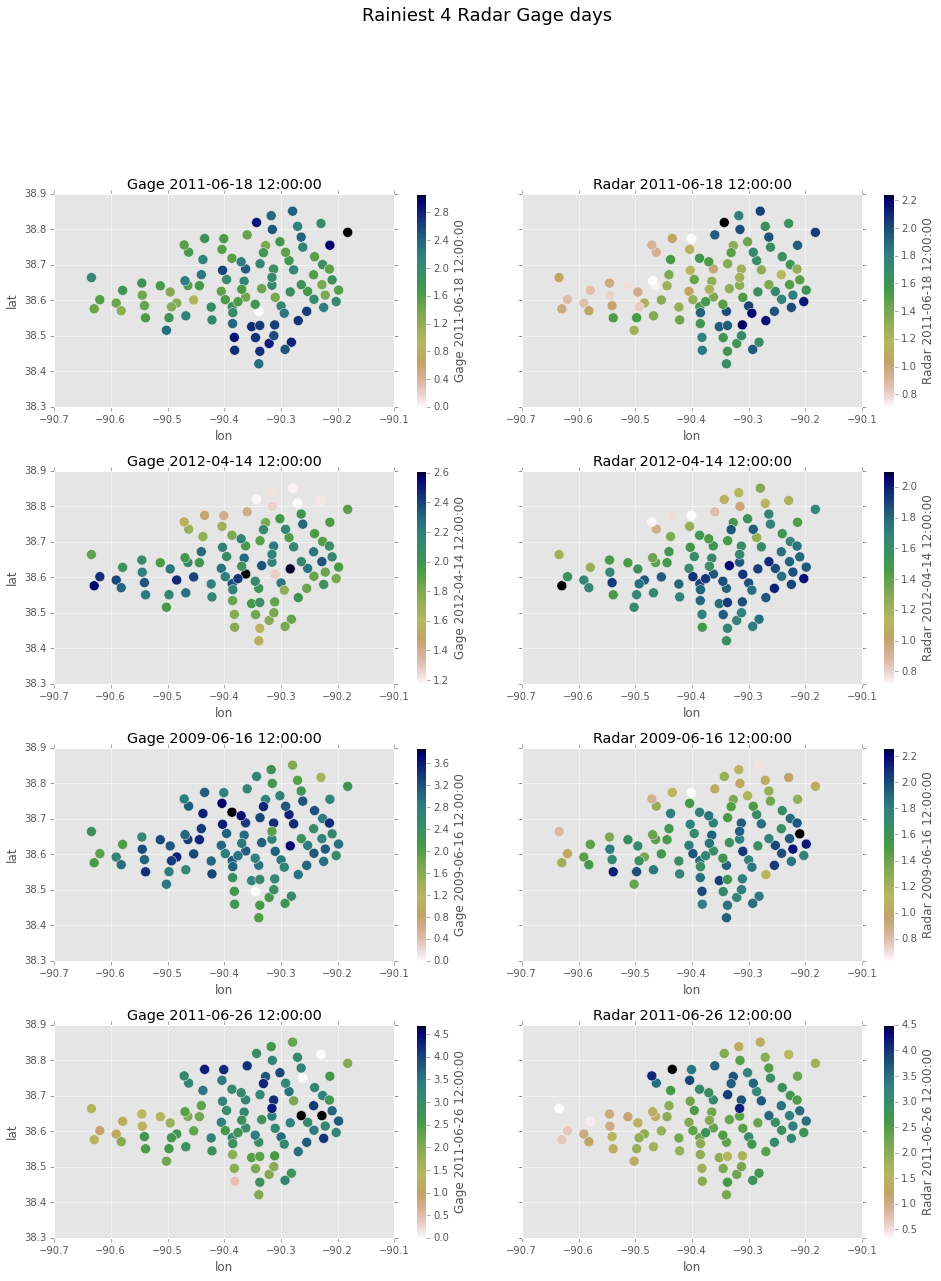

In [16]:
map_rain(p.rainiest, title='Rainiest 4 Radar Gage days', save_path=p.save_path)

In [12]:
rad.get_rainiest_days(4)

In [13]:
rad.rainiest.head()

,lat,lon,RG,Y,X,2011-06-18 12:00:00,2012-04-14 12:00:00,2009-06-16 12:00:00,2011-06-26 12:00:00
RG,,,,,,,,,
RG1,38.70079,-90.22650,RG1,4279.301153,48.710504,1.580833,1.666667,1.890909,2.709583
RG2,38.68573,-90.27758,RG2,4277.635909,42.621495,1.330417,1.602083,1.872727,3.722500
RG3,38.67198,-90.24237,RG3,4276.115517,44.174413,1.172917,1.770000,1.658701,3.438750
RG4,38.65759,-90.20977,RG4,4274.524357,45.432006,1.484167,1.799583,2.262857,3.523750
RG5,38.61467,-90.22187,RG5,4269.778521,39.682676,1.803750,1.870833,2.171429,3.248750


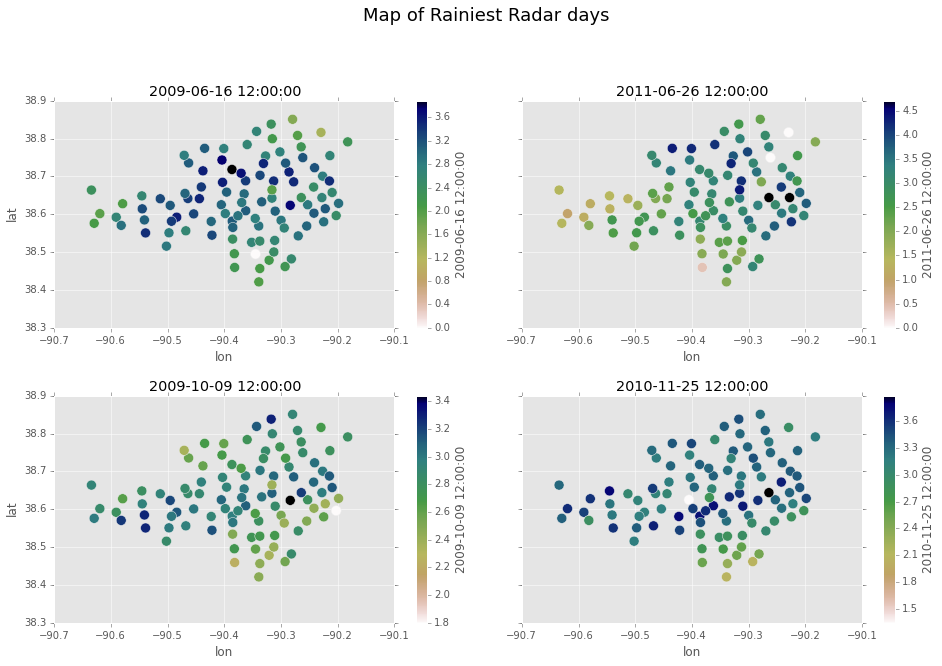

In [14]:
map_rain(rg.rainiest,title= 'Map of Rainiest Radar days', save_path=rg.save_path)

Now we can make a semi variogram of the rainiest days

In [17]:
storm = rg.rainiest[:]
for col in storm:
    if col not in rg.ll.columns:
        storm[col] = storm[col].replace(0, np.nan)
storm.to_csv('SVG_data', index=False)

In [28]:
d = {}
bar = {}
for i, col in enumerate(storm):
    if col not in rg.ll.columns:
        foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
                'source("SVG.r") \n'+
                'iSVG_tab <- get_iSVG(SVG_data, {index}, target_np=5, alpha=39, tol.hor=20, max_bnd=50)\n'.format(index=i+1)
                )
        df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['iSVG_tab']))
        try:
            df.index = df.dist
        except:
            continue
        d.update({col: df[:]})
        df.columns = ['np', 'dist', col, 'dir.hor', 'dir.vert', 'id']
        s = df[col]
        bar.update({col: s})
plotting_df = pd.DataFrame(bar.values()).transpose()

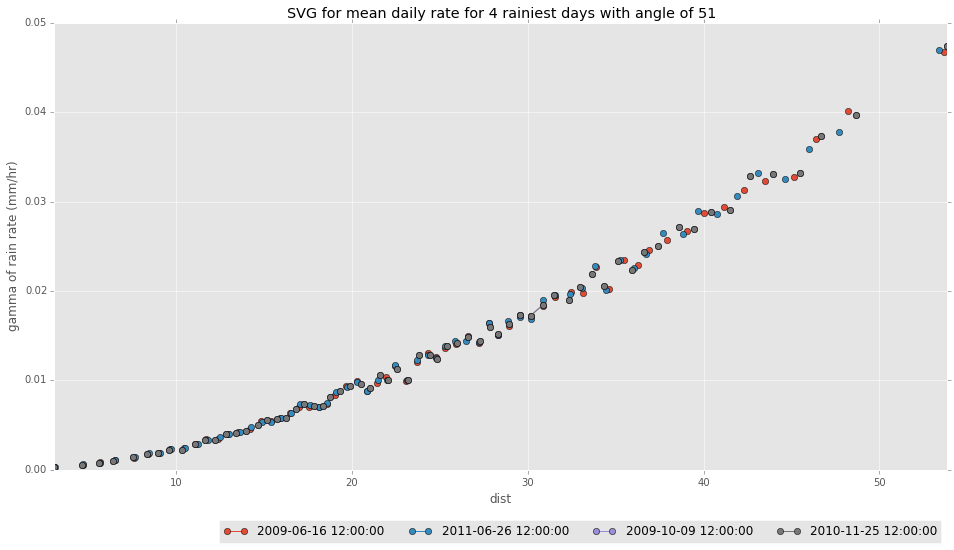

In [29]:
title = 'SVG for mean daily rate for 4 rainiest days with angle of 51'

plotting_df.plot(marker = 'o', figsize=(16,8))
plt.ylabel('gamma of rain rate (mm/hr)'),
plt.legend(bbox_to_anchor=(1, -.1), ncol = 5)
plt.title(title)
plt.savefig(rg.save_path+'{title}.jpg'.format(title=title))
plt.show()